## Research Journal 1
# Potential group (Bayan Taqi)
# <br> What I worked on this week.
<br> Configured the Python environment and paths to include the jeans research library for SIDM analysis.
<br> Wrote a get_data function to automatically parse SPARC .dat files and extract galaxy distances and metadata.Baryon Velocity
<br> Implemented Equation 8 to calculate the total baryon rotation curve ($V_b^2$) using specific mass-to-light ratios for the disk and bulge.
<br>Developed a numerical pipeline using Equation 9 and the trapezoid rule to derive the gravitational potential ($\Phi_b$) from the velocity data.Function Generation: Created a continuous potential function (phi_b_func) using cubic spline interpolation to allow the Jeans model to query data at any radius.
<br>Generated plots for NGC 7331 and CamB to compare individual baryon components (disk, gas, bulge) against the total calculated potential.

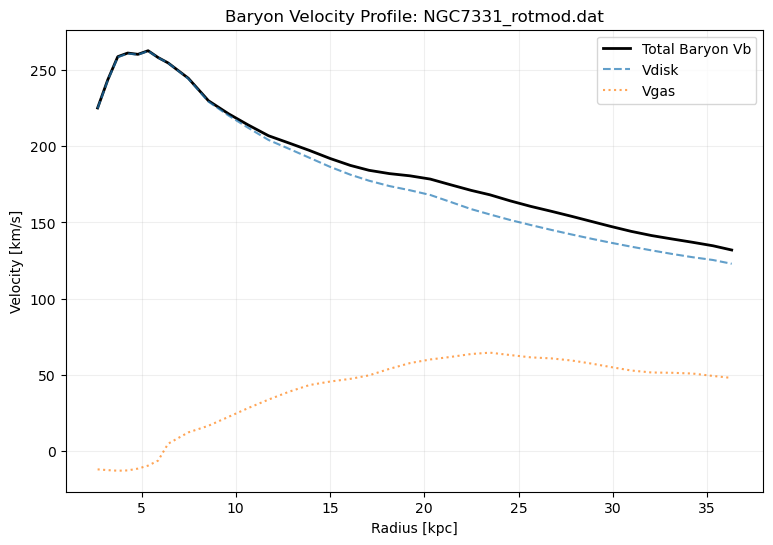

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d


sys.path.append('/Users/bayantaqi/Documents/Github/PHY2030/sidm-rotation-curves-SPARC/.sparcenv/lib/python3.11/site-packages')
import jeans

path = os.getcwd() + '/data/Rotmod_LTG/'
filename = path + 'NGC7331_rotmod.dat'

def get_data(filename):
    with open(filename) as f:
        lines = f.readlines()
    distance = float(lines[0].lstrip("# Distance = ").strip().split()[0])
    colnames = lines[1].lstrip("# ").split()
    units = lines[2].lstrip("# ").split()
    df = pd.read_csv(filename, comment="#", sep=r"\s+", names=colnames)
    units_df = pd.DataFrame([units], columns=colnames)
    return df, units_df, distance

df, units, dist = get_data(filename) 

# --- TASK 1: CALCULATE BARYON VELOCITY (Eq. 8) ---
ups_disk = 0.5
ups_bulge = 0.7

v_disk = df['Vdisk'] if 'Vdisk' in df.columns else 0
v_gas = df['Vgas'] if 'Vgas' in df.columns else 0
v_bulge = df['Vbulge'].fillna(0) if 'Vbulge' in df.columns else 0

# Calculate Vb^2 
v_b_sq = (ups_disk * v_disk**2 + 
          ups_bulge * v_bulge**2 + 
          v_gas**2)

df['Vb'] = np.sqrt(v_b_sq)

# --- TASK 2: RELATE VELOCITY TO POTENTIAL (Eq. 9) ---
r = df['Rad'].values
integrand = v_b_sq.values / r

# Numerical integration from r_max inward 
phi_values = []
for i in range(len(r)):
    val = -trapezoid(integrand[i:], r[i:])
    phi_values.append(val)

# Handle duplicates and create continuous function 
unique_r, indices = np.unique(r, return_index=True)
phi_b_func = interp1d(unique_r, np.array(phi_values)[indices], kind='cubic', fill_value="extrapolate")

# --- TASK 3: PLOT THE BARYON VELOCITY ---
plt.figure(figsize=(9, 6))
plt.plot(df['Rad'], df['Vb'], label='Total Baryon Vb', color='black', linewidth=2)
plt.plot(df['Rad'], np.sqrt(ups_disk)*v_disk, label='Vdisk', linestyle='--', alpha=0.7)
plt.plot(df['Rad'], v_gas, label='Vgas', linestyle=':', alpha=0.7)

plt.title(f'Baryon Velocity Profile: {os.path.basename(filename)}')
plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

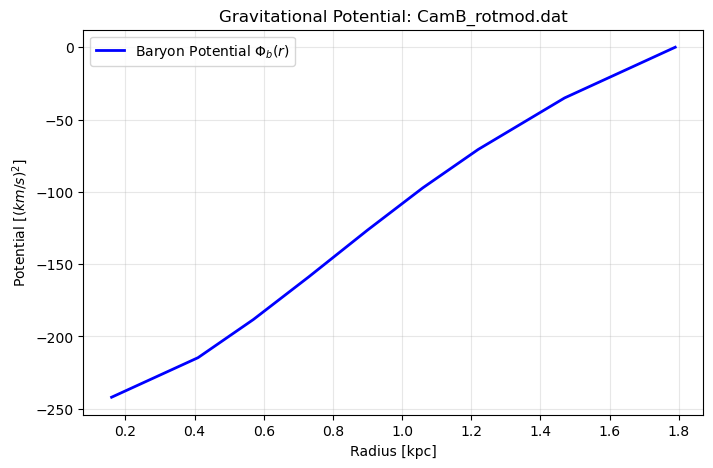

Baryon potential at 1.0 kpc: -107.94 (km/s)^2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

# 1. Setup environment and paths
sys.path.append('/Users/bayantaqi/Documents/Github/PHY2030/sidm-rotation-curves-SPARC/.sparcenv/lib/python3.11/site-packages')
import jeans

# Define your data path and filename
path = os.getcwd() + '/data/Rotmod_LTG/'
filename = path + 'CamB_rotmod.dat'

# 2. Define the data loading function
def get_data(filename):
    with open(filename) as f:
        lines = f.readlines()
    distance = float(lines[0].lstrip("# Distance = ").strip().split()[0])
    colnames = lines[1].lstrip("# ").split()
    units = lines[2].lstrip("# ").split()
    
    # Read the dataframe - this creates 'df' [cite: 206]
    df = pd.read_csv(filename, comment="#", sep=r"\s+", names=colnames)
    units_df = pd.DataFrame([units], columns=colnames)
    return df, units_df, distance

# 3. Call the function to create 'df'
df, units, dist = get_data(filename)

# --- TASK: CALCULATE VELOCITY AND RELATE TO POTENTIAL ---
ups_disk = 0.5 
ups_bulge = 0.7 

# Check for components and calculate Vb^2 [cite: 208, 217]
v_disk = df['Vdisk'] if 'Vdisk' in df.columns else 0
v_gas = df['Vgas'] if 'Vgas' in df.columns else 0
v_bulge = df['Vbulge'].fillna(0) if 'Vbulge' in df.columns else 0

v_b_sq = (ups_disk * v_disk**2 + ups_bulge * v_bulge**2 + v_gas**2)
df['Vb'] = np.sqrt(v_b_sq)

# Define radius and integrand for Eq. 9 [cite: 215, 219]
r = df['Rad'].values
integrand = v_b_sq.values / r

# 4. Perform Numerical Integration inward from r_max [cite: 219, 220]
phi_values = []
for i in range(len(r)):
    val = -trapezoid(integrand[i:], r[i:])
    phi_values.append(val)

phi_values = np.array(phi_values)

# 5. Handle Data Cleaning and Interpolation [cite: 223, 225]
unique_r, indices = np.unique(r, return_index=True)
unique_phi = phi_values[indices]
phi_b_func = interp1d(unique_r, unique_phi, kind='cubic', fill_value="extrapolate")

# --- VISUALIZATION ---
plt.figure(figsize=(8, 5))
plt.plot(unique_r, unique_phi, color='blue', linewidth=2, label='Baryon Potential $\Phi_b(r)$')
plt.xlabel('Radius [kpc]')
plt.ylabel('Potential $[(km/s)^2]$')
plt.title(f'Gravitational Potential: {os.path.basename(filename)}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Baryon potential at 1.0 kpc: {phi_b_func(1.0):.2f} (km/s)^2")